# Repeat result in Masich et. al using MOM025 DATA

Recent update 10 Aug 2017

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

# Topographic Stress term using


# No.1  $$F_{topog} = -\int_x \int_z (g*(\rho-\rho_0)*dz)*d\eta$$

###### $\rho_0=1035$

In [5]:
%%time
plt.figure(figsize=(8,4))

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
dxt = dsx1.dxt
dyt = dsx1.dyt
dyu = dsx1.dyu
dxu = dsx1.dxu
depth = dsx1.ht

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')

taux = dxu*dsx2.tau_x.mean('time')
tau_fric= dxu*dsx2.bmf_u.mean('time')
eta0 = dsx2.sea_level.mean('time')
pbot = dsx2.pbot_t.mean('time')

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup3/output006/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')

rho = dsx3.rho.mean('time')
dz = dsx3.dzt.mean('time')
press = dsx3.press.mean('time')
u = dsx3.u.mean('time')
v = dsx3.v.mean('time')


pair=101325
temp = -(rho-970)*dz*9.8196

p = temp.sum('st_ocean')-pair


deta=eta0.diff('xt_ocean')
ddepth=depth.diff('xt_ocean')

dpH = p*deta



/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


CPU times: user 22.6 s, sys: 26.4 s, total: 49 s
Wall time: 50.2 s


# Masich et.al Fig 1 repeat with MOM025 data

### 1.wind stress tau_x
### 2. integrated zonal pressure gradient : $p=\int \rho*g*dz$
### 3. bottom drag
### 4. meridional momentum flux divergence


CPU times: user 313 ms, sys: 11 ms, total: 324 ms
Wall time: 322 ms


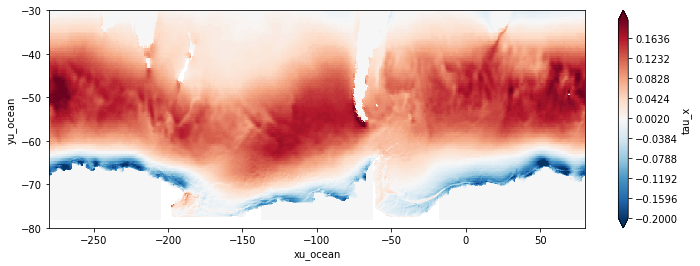

In [7]:
%%time
plt.figure(figsize=(12,4))

lev=np.linspace(-0.2,0.2,100)    
dsx2.tau_x.mean('time').plot(levels=lev)

plt.ylim([-80,-30])

CPU times: user 1.37 s, sys: 1.63 s, total: 3 s
Wall time: 3.03 s


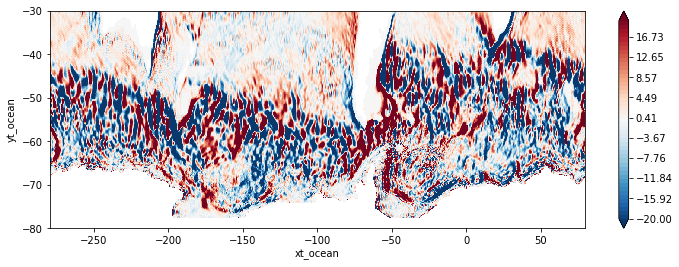

In [20]:
## use rho

%%time
plt.figure(figsize=(12,4))

temp2 = -(rho)*dz*9.8196
p2 = temp2.sum('st_ocean')
gradpz=p2*deta/dxt

lev=np.linspace(-20,20,50) 
gradpz.plot(levels=lev)

plt.ylim([-80,-30])

CPU times: user 269 ms, sys: 15 ms, total: 284 ms
Wall time: 285 ms


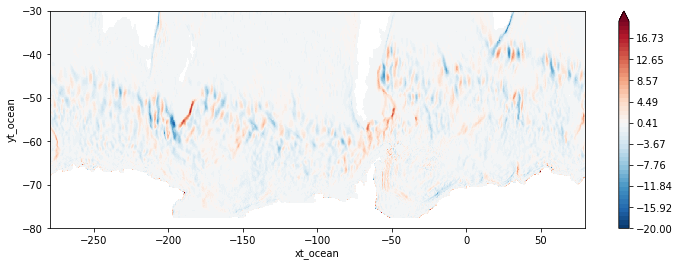

In [24]:
## \rho-\rho_ref

%%time
plt.figure(figsize=(12,4))

gradpz=dpH/dxt

lev=np.linspace(-20,20,50) 
gradpz.plot(levels=lev)

plt.ylim([-80,-30])

CPU times: user 241 ms, sys: 5 ms, total: 246 ms
Wall time: 246 ms


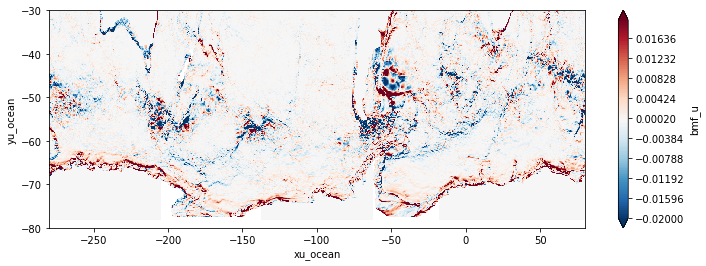

In [55]:
%%time
plt.figure(figsize=(12,4))

lev=np.linspace(-0.02,0.02,100)    
bmf = -dsx2.bmf_u.mean('time')
bmf.plot(levels = lev)

plt.ylim([-80,-30])

CPU times: user 848 ms, sys: 2.34 s, total: 3.19 s
Wall time: 3.19 s


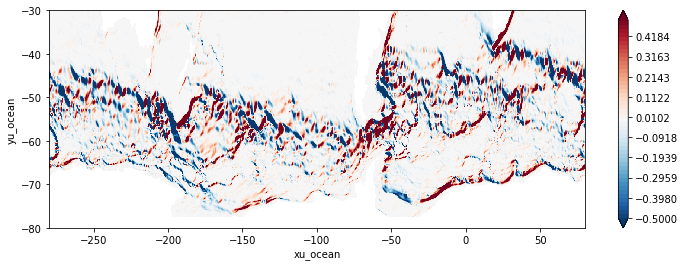

In [56]:
%%time
plt.figure(figsize=(12,4))

uv=u*v
dzu = uv.st_ocean.diff('st_ocean')
uvdz = uv*dzu
uvsum = uvdz.sum('st_ocean')
grady = uvsum*1035/dyu

lev=np.linspace(-0.5,0.5,50) 
grady.plot(levels=lev)

plt.ylim([-80,-30])


# Zonal and depth integrated stress (N/m) match with Masich et. al Figure 3

CPU times: user 2.4 s, sys: 748 ms, total: 3.15 s
Wall time: 3.15 s


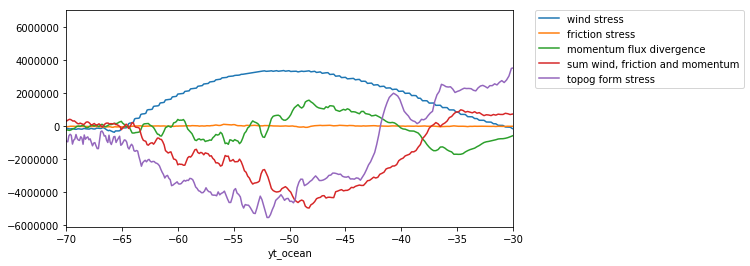

In [19]:
%%time
plt.figure(figsize=(8,4))

uv=u*v
dzu = dsx3.st_ocean.diff('st_ocean')
uvdz = uv*dzu
uvsum = uvdz.sum('st_ocean')

uvsum_corr=uvsum + uv.isel(st_ocean=0)*10.06
grad = -uvsum_corr*1035*dxu/dyu

temp = -(rho-920)*dz*9.8196

p = temp.sum('st_ocean')-pair


deta=eta0.diff('xt_ocean')
ddepth=depth.diff('xt_ocean')

dpH = p*deta
di_tau = -taux.sum('xu_ocean').isel(yu_ocean=np.arange(40,1080))+tau_fric.sum('xu_ocean').isel(yu_ocean=np.arange(40,1080))-grad.sum('xu_ocean').isel(yu_ocean=np.arange(40,1080))




taux.sum('xu_ocean').isel(yu_ocean=np.arange(40,1080)).plot(label="wind stress")
tau_fric.sum('xu_ocean').isel(yu_ocean=np.arange(40,1080)).plot(label="friction stress")
grad.sum('xu_ocean').isel(yu_ocean=np.arange(40,1080)).plot(label="momentum flux divergence")
di_tau.plot(label="sum wind, friction and momentum")
dpH.sum('xt_ocean').isel(yt_ocean=np.arange(40,1080)).plot(label="topog form stress")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim([-70,-30]) 